In [1]:
from __future__ import division

import numpy as np

from scipy.integrate import ode

import math

import matplotlib.pyplot as plt

from numpy.linalg import inv

import sys

from scipy.optimize import minimize

import dubins
import random

In [2]:
def mat_mult(a,b):
    return np.dot(a,b)

In [3]:
def lst_mult(c,d):
    return np.dot((np.array(c)),(np.array(d)))

In [4]:
def transpose_matrix(f):
    try:
        no_rows = f.shape[0]
        no_columns = f.shape[1]
    except IndexError:
        no_rows = 1
        no_columns = f.shape[0]

    u = f.T
    transpose = u.reshape(no_columns,no_rows)
    return transpose

In [5]:
def normalize_angle(theta):
    return math.atan2(math.sin(theta), math.cos(theta))

In [6]:
def conx_y(j):
    def kinematics(z):       ## j from 1 to N
        x,y,theta,xn,yn,thetan = z[2*N + 3*j -3 : 2*N + 3*j +3]
        dv,dw = z[2*j : 2*j +2]
        vref = u_ref[j,0]
        wref = u_ref[j,1]
        out = [xn - x - (dv + vref) * math.cos(theta) * Ts, yn - y - (dv + vref) * math.sin(theta) * Ts, thetan - theta - (dw + wref)*Ts]
        return np.array(out)
    return kinematics

def conx_y_jac(j):
    def jac_kinematics(z):
        T = np.zeros((3, 5*N))
        x,y,theta,xn,yn,thetan = z[2*N + 3*j -3 : 2*N + 3*j +3]
        dv,dw = z[2*j : 2*j +2]
        ix,iy,itheta,ixn,iyn,ithetan = range(2*N + 3*j -3 , 2*N + 3*j +3)
        idv,idw = range(2*j , 2*j +2)
        vref = u_ref[j,0]
        wref = u_ref[j,1]
        
        T[0,ix] = -1
        T[0,idv] = -math.cos(theta) * Ts
        T[0,itheta] = (dv + vref)* math.sin(theta) * Ts
        
        T[1,iy] = -1
        T[1,idv] = -math.sin(theta) * Ts
        T[1,itheta] = -(dv+vref)* math.cos(theta) * Ts
        
        T[2,itheta] = -1
        T[2,idw] = -Ts
        
        return T
    return jac_kinematics

In [7]:

def cost_function(z):
    
    qa = 5000
    qb = 5000
    qc = qa*100
    ra = 1
    rb = 1
    Q = np.array([[qa,0,0],[0,qb,0],[0,0,qc]])
    R = np.array([[ra,0],[0,rb]])
    
    du_lin = np.zeros((1,2*(N)))      ## N = no. of time steps considered between 2 waypoints 
    x_lin = np.zeros((1,3*(N)))      ## if 3 waypoints are considered together then N = N1 + N2
    
    cost = 0
    
    du_lin[0,:] = z[:2*N]
    x_lin[0,:] = z[2*N:]

    du = du_lin.reshape((N),2)
    x = x_lin.reshape((N),3)

    for j in range(N):
        u_des = du[j,:] + u_ref[j,:]
        x_err = x_ref[j,:] - x[j,:]
        
        a_temp = mat_mult(u_des, R)
        b_temp = mat_mult(a_temp,transpose_matrix(u_des) )
        cost += b_temp[0]
        
        c_temp = mat_mult(x_err,Q)
        d_temp = mat_mult(c_temp, transpose_matrix(x_err))

        cost += d_temp[0]
    
            
    return cost / 1000

def cost_jac(z):
    qa = 5000
    qb = 5000
    qc = qa*100
    ra = 1
    rb = 1
    U = np.zeros((1, 5*N))
    for j in range(N):
        
        xi,yi,thetai = range(2*N + 3*j, 2*N + 3*j +3)
        dvi,dwi = range(2*j, 2*j +2)
        
#         U[0, dvi] = 2* z[dvi]  *ra
#         U[0, dwi] = 2* z[dwi] * rb
#         U[0, xi] = 2* (z[xi] - x_ref[j,0]) * qa
#         U[0, yi] = 2* (z[yi] - x_ref[j,1]) * qb
#         U[0, thetai] = 2* (z[thetai] - x_ref[j,2]) * qc
        U[0, dvi] = 2* (z[dvi] + u_ref[j,0])  *ra
        U[0, dwi] = 2* (z[dwi]+ u_ref[j,1]) * rb
        U[0, xi] = 2* (z[xi] - x_ref[j,0]) * qa
        U[0, yi] = 2* (z[yi] - x_ref[j,1]) * qb
        U[0, thetai] = 2* (z[thetai] - x_ref[j,2]) * qc
    return U / 1000
    

In [8]:
N_H = 10
N = 5
Ts = 0.1

x_curr = 0.4
y_curr = 0.4
theta_curr = 1

opt_dvel_repo = []
opt_domega_repo = []

opt_vel_repo = []
opt_omega_repo = []

X_curr_repo = [x_curr]
Y_curr_repo = [y_curr]
Theta_curr_repo = [theta_curr]

x_ref_repo = np.array([
    [  0.439,   0.439,   1.127],
       [  0.759,   1.112,   1.286],
       [  0.977,   1.855,   1.35 ],
       [  1.148,   2.617,   1.359],
       [  1.312,   3.381,   1.319],
       [  1.506,   4.134,   1.202],
       [  1.804,   4.905,   1.117],
       [  2.158,   5.631,   1.077],
       [  2.542,   6.344,   1.057],
       [  2.941,   7.05 ,   1.042]
])
# x_ref_repo = np.array(
#     [[  0.759,   1.112,   1.286],
#        [  0.977,   1.855,   1.35 ],
#        [  1.148,   2.617,   1.359],
#        [  1.312,   3.381,   1.319],
#        [  1.506,   4.134,   1.202],
#        [  1.804,   4.905,   1.117],
#        [  2.158,   5.631,   1.077],
#        [  2.542,   6.344,   1.057],
#        [  2.941,   7.05 ,   1.042],
#        [  3.35 ,   7.75 ,   1.024]])

u_ref_repo = np.array([
    [ 7.45 ,  1.589],
       [ 7.743,  0.643],
       [ 7.81 ,  0.093],
       [ 7.815, -0.407],
       [ 7.781, -1.164],
       [ 8.258, -0.853],
       [ 8.082, -0.399],
       [ 8.101, -0.204],
       [ 8.106, -0.144],
       [ 8.107, -0.186]
])
# u_ref_repo = np.array([[ 7.743,  0.643],
#        [ 7.81 ,  0.093],
#        [ 7.815, -0.407],
#        [ 7.781, -1.164],
#        [ 8.258, -0.853],
#        [ 8.082, -0.399],
#        [ 8.101, -0.204],
#        [ 8.106, -0.144],
#        [ 8.107, -0.186],
#        [ 8.104, -0.34 ]])

for k in range(N_H):
    x_ref_repo[k,2] = normalize_angle(x_ref_repo[k,2])
    
for kl in range(N_H - N +1):
    xref = np.array([[x_ref_repo[kl,:]],[x_ref_repo[kl+1,:]],[x_ref_repo[kl+2,:]],[x_ref_repo[kl+3,:]],[x_ref_repo[kl+4,:]]])
    x_ref = xref.reshape(N , 3)
    
    uref = np.array([[u_ref_repo[kl,:]],[u_ref_repo[kl+1,:]],[u_ref_repo[kl+2,:]],[u_ref_repo[kl+3,:]],[u_ref_repo[kl+4,:]]])
    u_ref = uref.reshape(N , 2)

    tb = []
    x0 = []
    
    for ijk in range(2*N):
        if ijk<N:
            tb.append((-10,10))
            tb.append((-10, 10))
            
            x0.append(0.5)
            x0.append(0.5)
            
        
        else:
            tb.append((None, None))
            tb.append((None, None))
            tb.append((None, None))
            
            x0.append(0.5)
            x0.append(0.5)
            x0.append(0.5)
            
    con = []
    con.append({'type':'eq', 'fun': lambda z: z[2*N] - x_curr - (z[0] + u_ref[0,0])* math.cos(theta_curr)* Ts})
    con.append({'type':'eq', 'fun': lambda z: z[2*N + 1] - y_curr - (z[0] + u_ref[0,0])* math.sin(theta_curr)* Ts})
    con.append({'type':'eq', 'fun': lambda z: z[2*N + 2] - theta_curr - (z[1] + u_ref[0,1])* Ts})

    for j in range(1, N):
        con.append({'type': 'eq', 'fun': conx_y(j)})#, 'jac': conx_y_jac(j) })
    

    

    res = minimize(cost_function, x0, method='SLSQP', bounds = tb,  jac = cost_jac ,constraints=con,options={'eps': sys.float_info.epsilon*10000, 'maxiter' : 10000, 'ftol': 0.00001 })

    print res
    res.x
    optimal_dcontrol_lin = np.zeros((1,2*N))
    optimal_states_lin = np.zeros((1,3*N))
#     for ij in range(5*(N)):
#             if ij < 2*(N):
#                 optimal_control_lin[0,ij] = res.x[ij]
#             else:
#                 optimal_states_lin[0,ij-2*N] = res.x[ij]
    
    optimal_dcontrol_lin[0,:] = res.x[:2*N]
    optimal_states_lin[0,:] = res.x[2*N:]
    
    optimal_dcontrol = optimal_dcontrol_lin.reshape(N,2)
    optimal_states = optimal_states_lin.reshape(N,3)
    
    
#     x_curr = (optimal_states[0,0])+(random.uniform(-0.2,0.2))
#     y_curr = (optimal_states[0,1])+(random.uniform(-0.2,0.2))
#     theta_curr = (optimal_states[0,2])+(random.uniform(-0.05,0.05))
    
    x_curr = (optimal_states[0,0])
    y_curr = (optimal_states[0,1])
    theta_curr = (optimal_states[0,2])
    
    
    
    X_curr_repo.append(x_curr)
    Y_curr_repo.append(y_curr)
    Theta_curr_repo.append(theta_curr)
    
    opt_dvel_repo.append(optimal_dcontrol[0,0])
    opt_domega_repo.append(optimal_dcontrol[0,1])
    
    opt_vel_repo.append(optimal_dcontrol[0,0] + u_ref[0,0])
    opt_omega_repo.append(optimal_dcontrol[0,1] + u_ref[0,1])
    
    for cons in con:
        print cons['fun'], cons['fun'](res.x), cons['type']
    

     fun: 0.24236611760143656
     jac: array([  1.41866722e-03,   2.53556885e-03,   1.46182380e-02,
         3.18025232e-03,   1.54234046e-02,   1.28136851e-03,
         1.55233060e-02,   1.81301228e-04,   1.53736901e-02,
        -7.98351685e-04,  -6.74531930e-03,   2.06883663e-01,
        -2.21557537e-01,  -6.69583731e-02,   7.72592050e-02,
        -2.08941428e-01,  -7.87170611e-02,   4.78749765e-02,
        -1.40515841e-01,  -8.77989892e-02,   8.62380493e-04,
        -7.54544449e-02,  -1.11332489e-01,  -1.24180746e-01,
         6.96132513e-03,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 28
     nit: 23
    njev: 23
  status: 0
 success: True
       x: array([-6.74066639, -0.32121558, -0.43388098,  0.94712616, -0.09829769,
        0.54768426, -0.053347  ,  0.49765061, -0.09415494,  0.76482416,
        0.43832547,  0.45968837,  1.12677844,  0.75230416,  1.11972592,
        1.28579106,  0.96912829,  1.8597875 ,  1.34985948,  1.1392201 ,
        2.6170

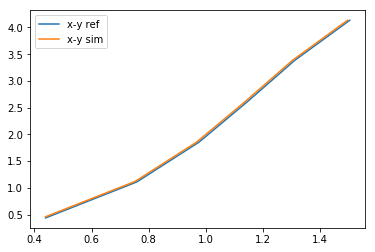

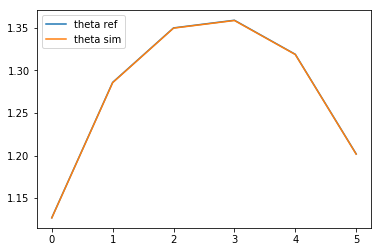

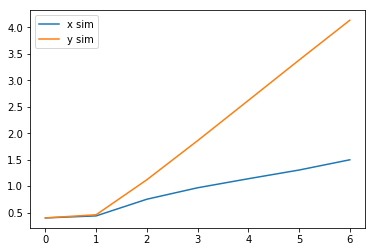

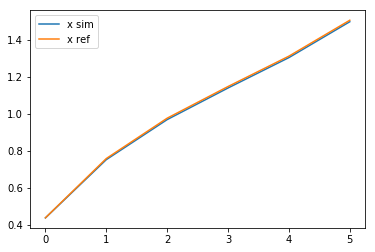

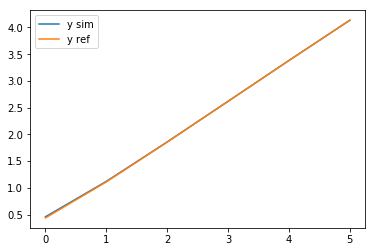

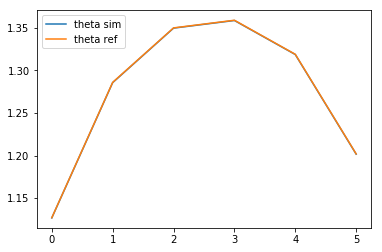

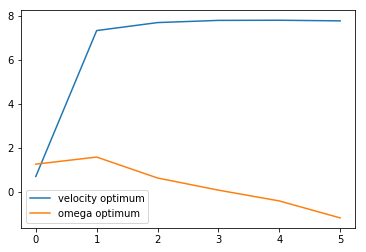

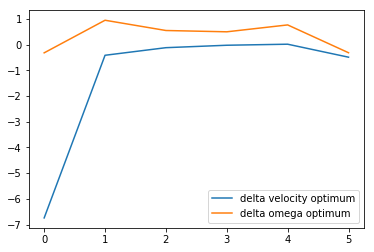

In [9]:
plt.plot(x_ref_repo[:6,0], x_ref_repo[:6,1], label = 'x-y ref')

plt.plot(X_curr_repo[1:],Y_curr_repo[1:], label = 'x-y sim')
plt.legend()
plt.show()
plt.plot(x_ref_repo[:6,2], label = 'theta ref')
plt.plot(Theta_curr_repo[1:], label = 'theta sim')
plt.legend()
plt.show()
plt.plot(X_curr_repo[:],label = 'x sim')
plt.plot(Y_curr_repo[:],label = 'y sim')
plt.legend()
plt.show()
plt.plot(X_curr_repo[1:],label = 'x sim')
plt.plot(x_ref_repo[:6,0],label = 'x ref')
plt.legend()
plt.show()
plt.plot(Y_curr_repo[1:],label = 'y sim')
plt.plot(x_ref_repo[:6,1],label = 'y ref')
plt.legend()
plt.show()
plt.plot(Theta_curr_repo[1:],label = 'theta sim')
plt.plot(x_ref_repo[:6,2],label = 'theta ref')
plt.legend()
plt.show()
plt.plot(opt_vel_repo[:], label = 'velocity optimum')
plt.plot(opt_omega_repo[:], label = 'omega optimum')
plt.legend()
plt.show()

plt.plot(opt_dvel_repo[:], label = 'delta velocity optimum')
plt.plot(opt_domega_repo[:], label = 'delta omega optimum')
plt.legend()
plt.show()


In [10]:
# turning_radius = 2
# step_size = 4 / 20.

# start = (0, 0, math.radians( 90))
# end   = (2, 0, math.radians(-90))
# qs, _ = dubins.path_sample(start, end, turning_radius, step_size)

# plt.plot([x[0] for x in qs], [x[1] for x in qs])
# plt.show()

In [11]:
# qs